<a href="https://colab.research.google.com/github/miller00315/i18n_flutter/blob/master/pytorch_custom_dataset_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytroch Custom dataset

## 0. Import PyTorch and setting up agnostic device

In [1]:

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Download pizza data if it doesn't exist

if image_path.is_dir():
    print(f"Image directory exists {image_path}")
else:
    print(f"Image directory does not exist {image_path}")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi dta
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Image directory does not exist data/pizza_steak_sushi
Unzipping pizza, steak, sushi data...


## 2. Becomming one with the data

In [4]:
import os

def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [5]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing a image

Random image path: data/pizza_steak_sushi/train/steak/355715.jpg
Image height: 382
Image width: 512


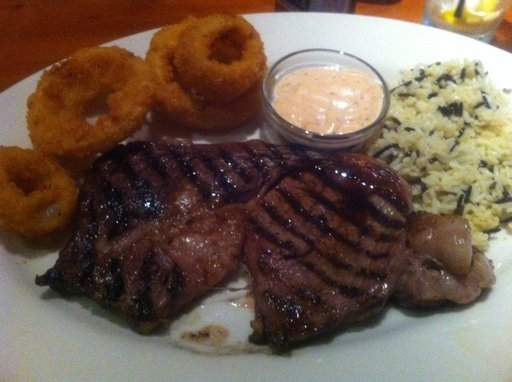

In [6]:
import random
from PIL import Image

random.seed(42)

#1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image = random.choice(image_path_list)

image_class = random_image.parent.stem

#3. Pick a random image path
img = Image.open(random_image)

print(f"Random image path: {random_image}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

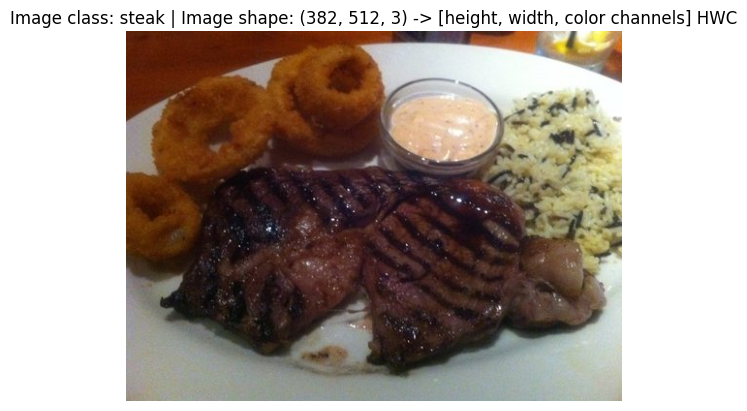

In [7]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.array(img)

plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color channels] HWC")
plt.axis(False);


## 3. Transforming data

### 3.1 Transformin dta with `torchvision.transforms`

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize our images
    transforms.RandomHorizontalFlip(p=0.5), # Flipe the images randomly
    transforms.ToTensor() # Turn image into a torch tensor
])

In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

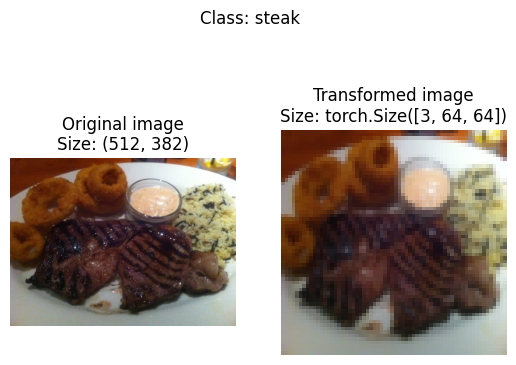

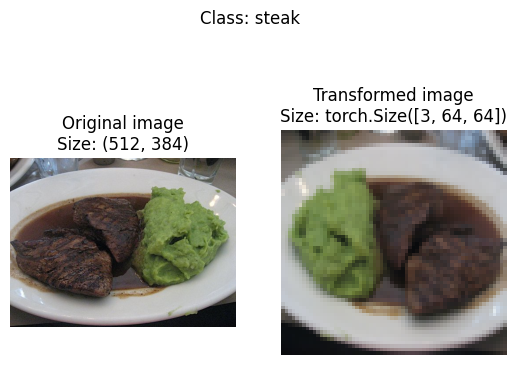

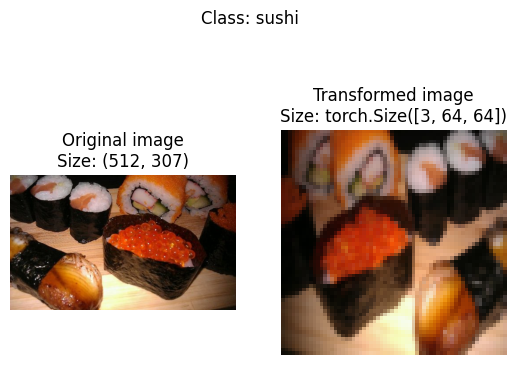

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image\nSize: {f.size}")
      ax[0].axis(False)

      transformed_img = transform(f) # Note we will need to change shape
      ax[1].imshow(transformed_img.permute(1, 2, 0)) # Note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].set_title(f"Transformed image\nSize: {transformed_img.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}")
      plt.show()

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
  )

## 4. Loaging images using `ImageFolder`

In [14]:
# Use IMageFolder to create datset(s)

from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
  )

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
  )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor: zn{img}")
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: zntensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

In [21]:
class_names[label]

'pizza'

Image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


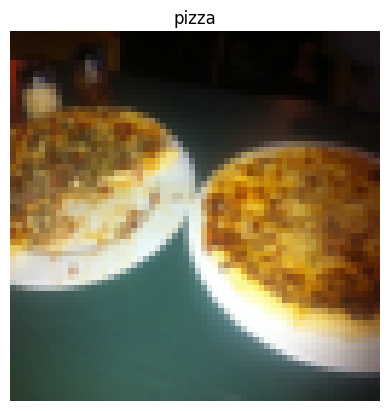

In [25]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Image shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);

## 4.1 Tund loaded images into `DataLoaders`

In [26]:
import os

os.cpu_count()

2

In [28]:
# Turn train and test datasets into DataLoaser's

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79494af9eef0>,
 <torch.utils.data.dataloader.DataLoader at 0x79494af9e8c0>)

In [29]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [31]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [32]:
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [33]:
# Setup path for target directory
target_directory = train_dir

print(f"target dir: {target_directory}")

class_names_found = sorted([item.name for item in (os.scandir(target_directory))])
class_names_found

target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [35]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [42]:
def find_classes(target_directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the classes folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # 2 Raise an erro if class name could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {target_directory}.. please check file structure")

  # Create a dictionary of index labels (computers prefer numbers rather thna strings as labels)
  class_to_idx = {class_name: item for item, class_name in enumerate(classes)}

  return classes, class_to_idx

In [43]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [48]:
# 0. Write a custom dataset class
import pathlib

# 1. Subclass torch.uitls.data.Dataset
class ImageFolderCustom(Dataset):
  # 2.initialize our custom dataset
  def __init__(
      self,
      target_dir: str,
      transform=None):
    # 3. Create class attibutes
    # Get all of the image paths
    self.target_dir = target_dir
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(target_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens a image by a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total numbers of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, dta and lable (X, y)."
    img = self.load_image(index)

    class_name = self.paths[index].parent.name # expects path in format: dta_folder/class_name/image.jpg

    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)

    return img, class_idx # return untransfomed data, label(X, y)


In [49]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't flip or manipulate test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transforms)

In [51]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79494ae51360>,
 <__main__.ImageFolderCustom at 0x79494ae52fb0>)

In [52]:
len(train_data), len(train_data_custom)

(225, 225)

In [53]:
len(test_data), len(test_data_custom)

(75, 75)

In [54]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [55]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
assert train_data.classes == train_data_custom.classes
assert train_data.class_to_idx == train_data_custom.class_to_idx

### 5.3 Create a function to display random images

In [56]:
# 1. Create a function to take in a adataset
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None):
  """Display a random selection of images from a dataset."""
  # 2. Adjust display if n is too high
  if n > 10:

    n = 10

    display_shape = False

    print("For display, purposes, 'n' shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Setup random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setuo plot
  plt.figure(figsize=(16, 6))

  # 6. Loop through radom index and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for ploting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # 8. Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)

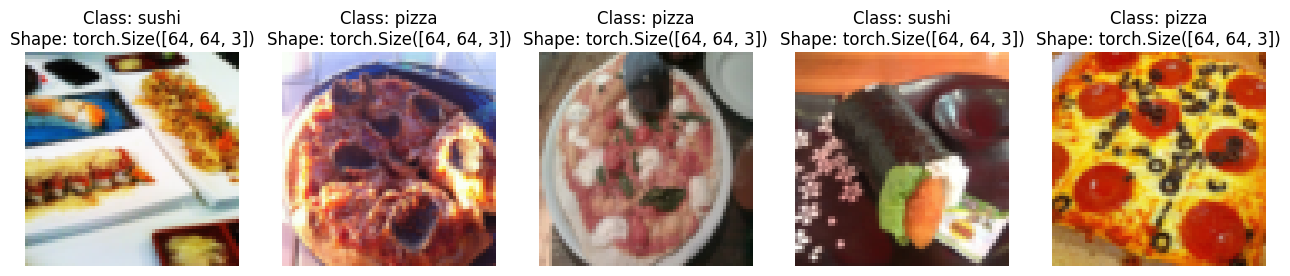

In [59]:
# Disply random images from the ImageFolder
display_random_images(dataset=train_data, classes=train_data.classes, n=5, seed=42)

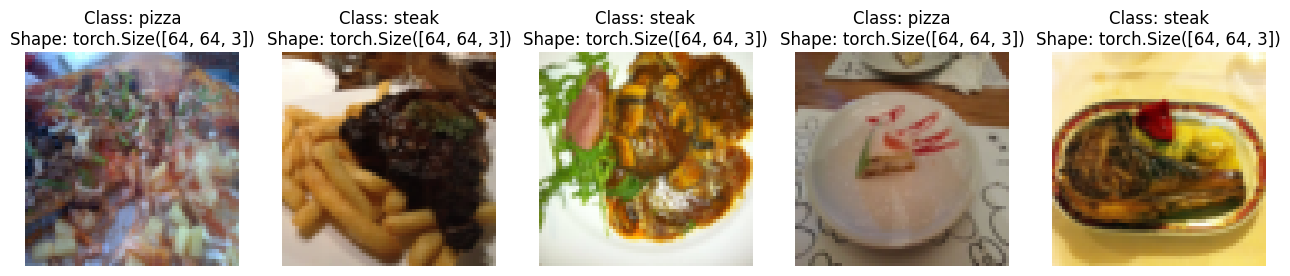

In [60]:
# Disply random image from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom, classes=train_data_custom.classes, n=5, seed=42)

### 5.4 Turn custom loaded into `DataLoaser`s

In [61]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False # Don't shuffle the test data
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7949459c3b20>,
 <torch.utils.data.dataloader.DataLoader at 0x7949459c2650>)

In [62]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 6. Other forms of transforoms (data augmetation)


In [63]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
  ])

In [64]:
# Get al image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/steak/1849463.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2881783.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg')]

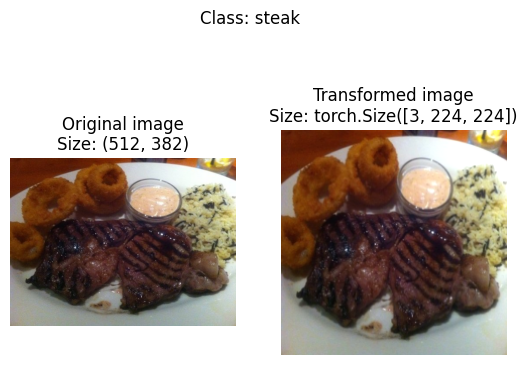

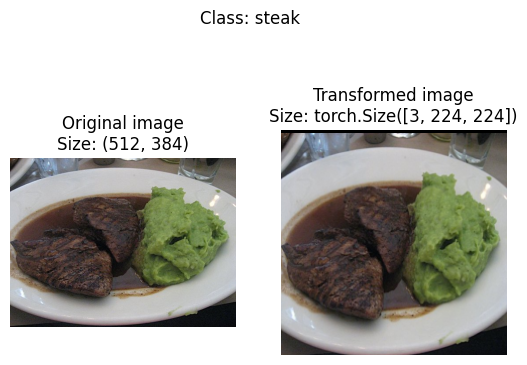

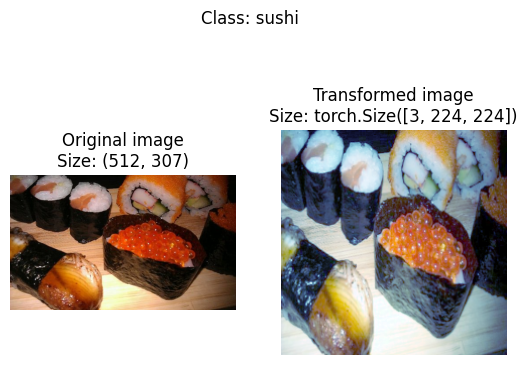

In [67]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=42
)


## 7. Model 0: TinyGG without data augmentation

### 71. Creating transforms and loading data for Model 0

In [68]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [69]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. Turn teh dtasets into DataLoaders

import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataLoader's
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
  )

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
  )


### 7.2 Create TinyVGG model class

In [72]:
class TinyVGG(nn.Module):
  """
    Model architecture copynig TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
  """
  def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
          ):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )

    self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )

    self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*16*16,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion


https://horace.io/brrr_intro.html

In [73]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3, # number of color channels in our image data
    hidden_units=10, #
    output_shape=len(class_names)
  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a foward pass on a single image

In [75]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [76]:
# try a foward pass

model_0(image_batch.to(device))[:2]

tensor([[0.0637, 0.0615, 0.0382],
        [0.0598, 0.0601, 0.0385]], grad_fn=<SliceBackward0>)

### 7. Use `torchinfo` to get a idea to teh shapes going through the model

In [79]:
# Instla torchinfo, inport if it's available
try:
  from torchinfo import summary
except ModuleNotFoundError:
  !pip install torchinfo
  from torchinfo import summary
  print("[INFO] torchinfo not found, installing it...")

[INFO] torchinfo not found, installing it...


In [80]:
summary(model=model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia